The scope of today’s exercises is to understand and calculate the market risk measures VaR and
ES on the final day of a data set (and also backtest one of more models). We are considering
an investment of $100,000 in the stock, a time-horizon of 1 day and confidence levels 95% and
99%.

1. (Download or load data) Download daily data for a stock in the S&P index. Make sure that
you have at least 5 years of data. If you do not know how to download data in Python, you
can use the uploaded data. Use the Adjusted closing prices to calculate past returns of the
stock. You will need these returns to calculate VaR and ES in multiple ways.

In [185]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

S = 100000
confidence_level = 95
N = 252

stock = "AMZN" # replace symbol with the ticker of the desired stock
start_date = "2018-02-01" # replace with the start date, 5 years before the current date
end_date = "2023-01-31" # replace with the end date, today's date
data = yf.download(stock, start=start_date, end=end_date, interval = "1d")


adj_close = data["Adj Close"]
returns = adj_close.pct_change()
returns = returns.dropna()

ret_fit = returns.iloc[:-N]
ret_test = returns.iloc[-N:]

[*********************100%***********************]  1 of 1 completed


2. (Plots) Make plot of the returns. Do they seem stationary (based on solely a visual inspec-
tion)? Plot a histogram or a density plot of past returns. Decide on a reasonable choice of
how many past returns to include. This should not be more than the size of the full data set
minus one years (in order to do later backtesting). DO NOT SPEND TOO MUCH TIME ON
CHOOSING THE NUMBER OF PAST RETURNS – IF YOU ARE UNSURE, THEN PICK
N = 252 DAYS OR N = 504 DAYS.

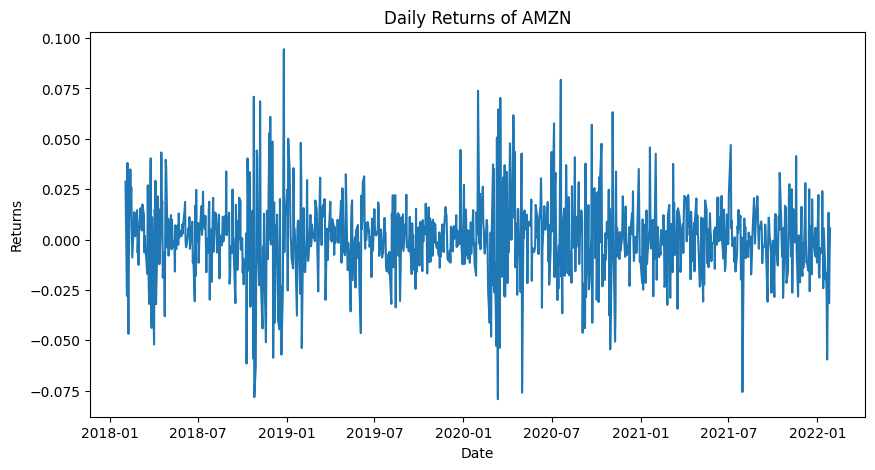

In [186]:
#plot the returns
plt.figure(figsize=(10,5))
plt.plot(ret_fit)
plt.title("Daily Returns of " + stock)
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()


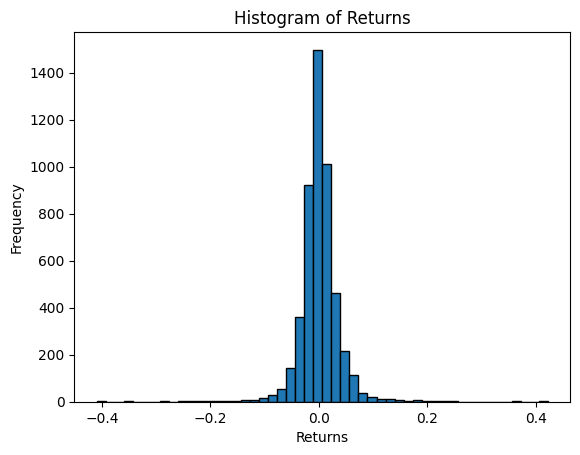

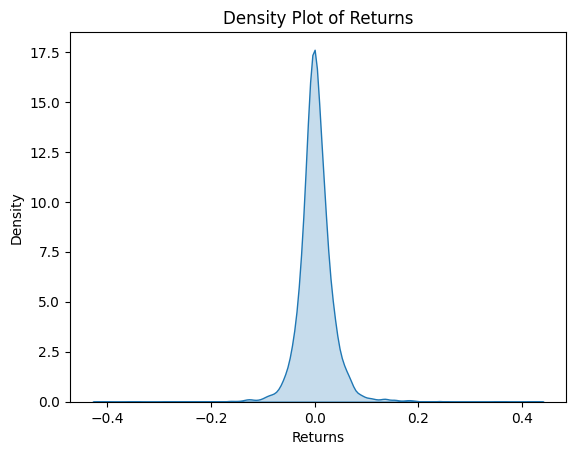

In [89]:
# Histogram Plot
plt.hist(ret_fit, bins=50, edgecolor='k')
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.title("Histogram of Returns")
plt.show()

# Density Plot
sns.kdeplot(ret_fit, fill=True)
plt.xlabel("Returns")
plt.ylabel("Density")
plt.title("Density Plot of Returns")
plt.show()

3. (Non-parametric assumption) Calculate VaR and ES based on a non-parametric assumption
similar to RM Section 19.2.1. You might find it useful to use the numpy function percentile
here (use the option: interpolation=’lower’) or sort the returns and pick the relevant lowest
number.

In [110]:
def calculate_var_es(returns, confidence_level):
    
    # Step 5: The VaR is equal to the return at the rank determined
    var = np.percentile(returns, confidence_level, method='lower')
    
    # Step 6: Calculate ES
    es = np.mean(returns[returns <= var])
    
    return var, es

In [117]:
def calculate_var_es_sorting(returns, confidence_level):
        
    # Step 1: Sort the returns in ascending order
    returns_sorted = np.sort(returns)
    
    # Step 2: Calculate the index of the return at the rank determined
    index = int((confidence_level / 100) * len(returns_sorted))
    
    # Step 3: The VaR is equal to the return at the rank determined
    var = returns_sorted[index]
    
    # Step 4: Calculate ES
    es = np.mean(returns_sorted[:index])
    
    return var, es

In [126]:
var, es = calculate_var_es_sorting(ret_fit.values, 5)
print(f"VaR: ${-S * var:.2f}")
print(f"ES: ${-S * es:.2f}")


VaR: $4513.89
ES: $7629.16


4. (Normal distributed data) Assume that returns are normally i.i.d. distributed. Calculate
VaR and ES. Under the normal assumption, the relevant quantile is μ + σΦ−1(α), where
Φ is the cumulative normal distribution. CONTINUE TO QUESTION 9 AND 10 BEFORE
RETURNING TO QUESTION 5-8.


In [132]:
from scipy.stats import norm

confidence_level = 0.05
stdev = np.std(ret_fit)
mean = np.mean(ret_fit)

VaR = -S * (mean + norm.ppf(confidence_level) * stdev)
ES = S * (mean + (norm.pdf(norm.ppf(confidence_level)) / (confidence_level)) * stdev)
print(f"VaR: ${VaR:.2f}")
print(f"ES: ${ES:.2f}")


VaR: $5685.80
ES: $7538.77


9. (Backtesting) Modify your code from any of the questions 3-4 (or 5-8 if you got that far)
and calculate VaR for each day in the past year. Compare VaR predictions with realisations
(for instance with a plot like in the slides) and do a formal backtest of your chosen model.

In [177]:
vars = []
ess = []
violations = []

for i in range(N*2, len(ret_fit)):

    var, es = calculate_var_es_sorting(ret_fit[:i].values, 5)

    vars.append(var*S)
    ess.append(es)



    if var * -S < ret_fit[i] * S:
        violations.append(1)
    else:
        violations.append(0)


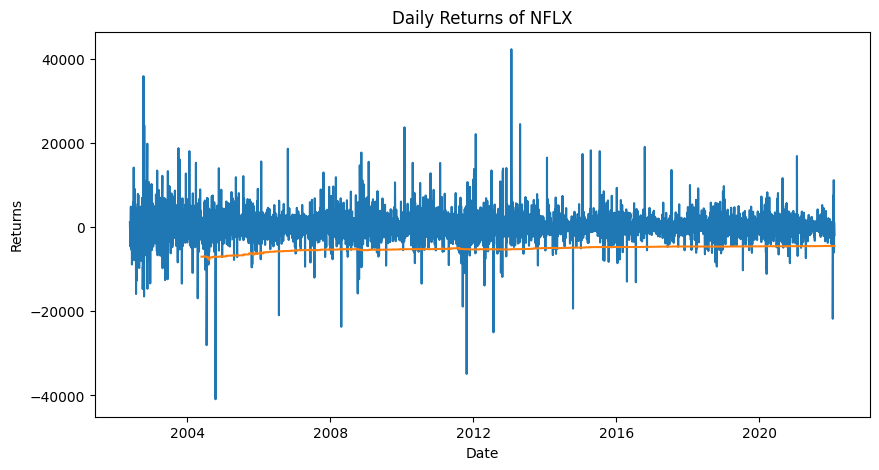

In [178]:
#plot returns and vars
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ret_fit*S, label="Returns")
ax.plot(ret_fit.index[N*2:], vars, label="VaR")
plt.title("Daily Returns of " + stock)
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()


for i, v in enumerate(violations):
    if v == 1:
        ax.axvline(x=ret_fit.index[i+2*N], color='r', linestyle='-')


In [181]:
# check the percentage of violations
# expectation is that it is lower than the confidence level

sum(violations) / (len(ret_fit) - 2*N)

0.044638851502916105

In [49]:
from arch import arch_model
from arch.__future__ import reindexing
reindexing = True
garch = arch_model(returns[1:], mean="Zero", vol="GARCH", p=1, q=1, rescale=False)
model_fit = garch.fit(disp="off")

In [50]:
from scipy.stats import norm

forecast = model_fit.forecast(horizon=1)
volatility = forecast.variance.values[-1, :]

confidence_level = 0.05
VaR = -np.sqrt(volatility) * norm.ppf(confidence_level)
ES = -np.sqrt(volatility) * norm.pdf(norm.ppf(confidence_level)) / (1 - confidence_level)


In [51]:
vol_series = model_fit.conditional_volatility
next_day_vol = forecast.variance.values[-1, :][0]
standardized_returns = returns / np.sqrt(vol_series)
rescaled_returns = standardized_returns * np.sqrt(next_day_vol)

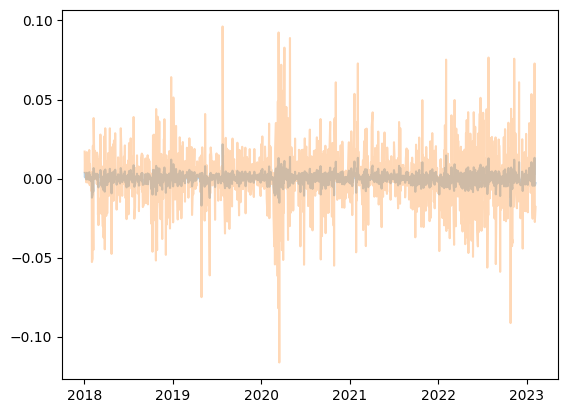

In [56]:
plt.plot(rescaled_returns, alpha=0.3)
plt.plot(returns, alpha=0.3)

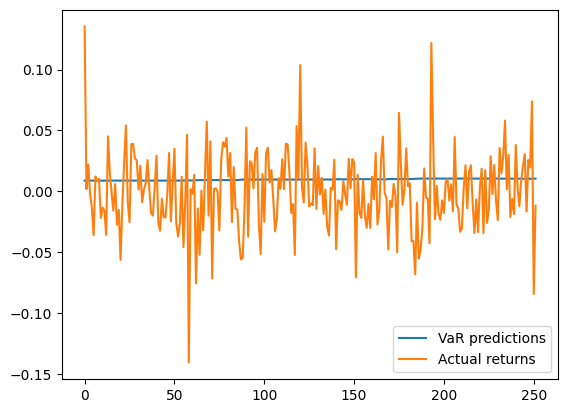

Number of violations:  100
Violation rate:  0.3968253968253968


In [39]:
import numpy as np
import pandas as pd
from arch import arch_model
from scipy.stats import norm

ret = returns[1:]

# Fit a GARCH(1,1) model to the data
model = arch_model(ret, mean='Zero', vol='GARCH', p=1, q=1, rescale=False)
model_fit = model.fit(disp='off')

# Get the forecast
forecast = model_fit.forecast(horizon=1)

# Get the next day's volatility
next_day_vol = forecast.variance.values[-1, :][0]

# Get the standardized returns
standardized_returns = ret / np.sqrt(model_fit.conditional_volatility)

# Get the rescaled returns
rescaled_returns = standardized_returns * np.sqrt(next_day_vol)

# Set the confidence level
confidence_level = 0.05

# Get the number of observations
num_obs = returns.shape[0]

# Calculate VaR for each day in the past year
var_list = []
for i in range(num_obs - 252, num_obs):
    rescaled_returns_i = rescaled_returns[:i]
    var = -np.percentile(rescaled_returns_i, 100 * confidence_level)
    var_list.append(var)
var_list = np.array(var_list)

# Plot the VaR predictions and actual returns
import matplotlib.pyplot as plt
plt.plot(var_list, label='VaR predictions')
plt.plot(ret.iloc[-252:].values, label='Actual returns')
plt.legend()
plt.show()

# Formal backtesting
backtest_results = []
for i in range(num_obs - 252, num_obs-1):
    actual_return = ret.iloc[i]
    if actual_return < -var_list[i - num_obs + 252]:
        backtest_results.append(1)
    else:
        backtest_results.append(0)

# Calculate the number of violations
num_violations = sum(backtest_results)

# Calculate the violation rate
violation_rate = num_violations / 252

# Print the results
print('Number of violations: ', num_violations)
print('Violation rate: ', violation_rate)


In [36]:
ret

Date
2020-01-03   -0.012139
2020-01-06    0.014886
2020-01-07    0.002092
2020-01-08   -0.007809
2020-01-09    0.004799
                ...   
2023-01-31    0.025659
2023-02-01    0.019587
2023-02-02    0.073799
2023-02-03   -0.084315
2023-02-06   -0.011703
Name: Adj Close, Length: 779, dtype: float64